# Import Packages

In [1]:
import torch
from glob import glob
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


from torch_lr_finder import LRFinder

C:\Users\kuvh\.conda\envs\cuda\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# General helper functions

In [2]:
def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False
        
def unfreeze_all(model_params):
    for param in model_params:
        param.requires_grad = True
        
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

def load_image(filename) :
    img = Image.open(filename)
    img = img.convert('RGB')
    return img

# Load the Resnet Model

In [3]:
resnet = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
resnet.eval()

Using cache found in C:\Users\kuvh/.cache\torch\hub\pytorch_vision_main
C:\Users\kuvh\.conda\envs\cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kuvh\.conda\envs\cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Get the data and do preprocessing

In [4]:
filenames = glob('./datasets/*.jpg')

In [5]:
classes = set()

data = []
labels = []

# Load the images and get the classnames from the image path
for image in filenames:
    class_name = image.rsplit("\\", 1)[1].rsplit('_', 1)[0]
    classes.add(class_name)
    img = load_image(image)

    data.append(img)
    labels.append(class_name)

# convert classnames to indices
class2idx = {cl: idx for idx, cl in enumerate(classes)}        
labels = torch.Tensor(list(map(lambda x: class2idx[x], labels))).long()

data = list(zip(data, labels))

In [6]:
class VehicleDataset(Dataset):
    "Dataset to serve individual images to our model"
    
    def __init__(self, data, transforms=None):
        self.data = data
        self.len = len(data)
        self.transforms = transforms
    
    def __getitem__(self, index):
        img, label = self.data[index]
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, label
    
    def __len__(self):
        return self.len


# Since the data is not split into train and validation datasets we have to 
# make sure that when splitting between train and val that all classes are represented in both
class Databasket():
    "Helper class to ensure equal distribution of classes in both train and validation datasets"
    
    def __init__(self, data, num_cl, val_split=0.2, train_transforms=None, val_transforms=None):
        class_values = [[] for x in range(num_cl)]
        
        # create arrays for each class type
        for d in data:
            class_values[d[1].item()].append(d)
            
        self.train_data = []
        self.val_data = []
        
        # put (1-val_split) of the images of each class into the train dataset
        # and val_split of the images into the validation dataset
        for class_dp in class_values:
            split_idx = int(len(class_dp)*(1-val_split))
            self.train_data += class_dp[:split_idx]
            self.val_data += class_dp[split_idx:]
            
        self.train_ds = VehicleDataset(self.train_data, transforms=train_transforms)
        self.val_ds = VehicleDataset(self.val_data, transforms=val_transforms)

In [7]:
from sklearn.model_selection import train_test_split

# Apply transformations to the train dataset
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply the same transformations to the validation set, with the exception of the
# randomized transformation. We want the validation set to be consistent
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

databasket = Databasket(data, len(classes), val_split=0.2, train_transforms=train_transforms, val_transforms=val_transforms)

In [8]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super(AdaptiveConcatPool2d, self).__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

def head_blocks(in_dim, p, out_dim, activation=None):
    "Basic Linear block"
    layers = [
        nn.BatchNorm1d(in_dim),
        nn.Dropout(p),
        nn.Linear(in_dim, out_dim)
    ]
    
    if activation is not None:
        layers.append(activation)
        
    return layers       
    
def create_head(nf, nc, bn_final=False):
    "Model head that takes in 'nf' features and outputs 'nc' classes"
    pool = AdaptiveConcatPool2d()
    layers = [pool, nn.Flatten()]
    layers += head_blocks(nf, 0.25, 512, nn.ReLU(inplace=True))
    layers += head_blocks(512, 0.5, nc)
    
    if bn_final:
        layers.append(nn.BatchNorm1d(nc, momentum=0.01))
    
    return nn.Sequential(*layers)
    
def requires_grad(layer):
    "Determines whether 'layer' requires gradients"
    ps = list(layer.parameters())
    if not ps: return None
    return ps[0].requires_grad

def cnn_model(model, nc, bn_final=False, init=nn.init.kaiming_normal_):
    "Creates a model using a pretrained 'model' and appends a new head to it with 'nc' outputs"
    
    # remove dense and freeze everything
    body = nn.Sequential(*list(model.children())[:-2])
    head = create_head(1024, nc, bn_final)
    
    model = nn.Sequential(body, head)
    
    # freeze the resnet34 base of the model
    freeze_all(model[0].parameters())
    
    # initialize the weights of the head
    for child in model[1].children():
        if isinstance(child, nn.Module) and (not isinstance(child, bn_types)) and requires_grad(child): 
            init(child.weight)
    
    return model

num_classes = len(classes)
model = cnn_model(resnet, num_classes, bn_final=True)

In [9]:
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [10]:
train_indices = list(range(len(databasket.train_ds)))
test_indices = list(range(len(databasket.val_ds)))

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Basic dataloader to retrieve mini-batches from the datasets
train_loader = DataLoader(databasket.train_ds, batch_size=64, sampler=train_sampler, shuffle=False, num_workers=0)
test_loader = DataLoader(databasket.val_ds, batch_size=64, sampler=test_sampler, shuffle=False, num_workers=0)

In [11]:

criterion = torch.nn.CrossEntropyLoss()

# We don't actually use the learning rate here. It's set to 1e-7 so that the LR Finder
# starts at 1e-7
optimizer = optim.Adam(model.parameters(), lr=1e-7,  weight_decay=1e-5)

100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.43E-03


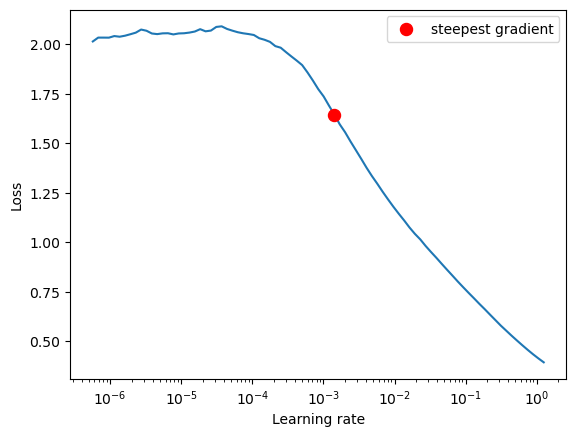

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.0014254639964445598)

In [12]:
# used to find the ideal LR for our model training
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=3, num_iter=100)
lr_finder.plot()

In [13]:
# A one cycle LR scheduler (https://arxiv.org/abs/1708.07120)
# max_lr is derived from the lr_finder plot
# epochs must match the amount of epochs you will run
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-2, pct_start=0.3, steps_per_epoch=len(train_loader), epochs=15)

In [14]:
device = 'cuda:0'
model.to(device)

def train(epochs, scheduler, optimizer, model):
    for epoch in range(epochs):
        running_loss = 0
        n_correct = 0
        
        # use dropouts and batchnorms
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
        train_acc = 100. * n_correct / len(databasket.train_ds)
        train_loss = running_loss / len(train_loader)
        
        n_val_correct = 0
        val_loss = 0
        
        # disable batchnorm and dropouts
        model.eval()
        # don't calculate gradient
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                val_loss = criterion(outputs, labels).item()

                n_val_correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
                
                
                
        val_acc = 100. * n_val_correct / len(databasket.val_ds)
                
                
                
            
        print('Epoch %s: Train Accuracy: %.2f percent, Validation Accuracy: %.2f percent, Train Loss: %s, Validation Loss: %s' 
              % (epoch, train_acc, val_acc, train_loss, val_loss))
        
train(15, scheduler, optimizer, model)

Epoch 0: Train Accuracy: 100.00 percent, Validation Accuracy: 55.56 percent, Train Loss: 0.0024065428297035396, Validation Loss: 11.793268203735352
Epoch 1: Train Accuracy: 100.00 percent, Validation Accuracy: 55.56 percent, Train Loss: 0.006773354718461633, Validation Loss: 9.826872825622559
Epoch 2: Train Accuracy: 100.00 percent, Validation Accuracy: 51.85 percent, Train Loss: 0.004478022106923163, Validation Loss: 8.471877098083496
Epoch 3: Train Accuracy: 98.02 percent, Validation Accuracy: 59.26 percent, Train Loss: 0.044340115040540695, Validation Loss: 7.618027687072754
Epoch 4: Train Accuracy: 100.00 percent, Validation Accuracy: 59.26 percent, Train Loss: 0.0044342182809486985, Validation Loss: 6.838955402374268
Epoch 5: Train Accuracy: 100.00 percent, Validation Accuracy: 59.26 percent, Train Loss: 0.002514512074412778, Validation Loss: 6.26009464263916
Epoch 6: Train Accuracy: 100.00 percent, Validation Accuracy: 59.26 percent, Train Loss: 0.0014648385113105178, Validation 

In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, './models/vehicle_1.pt')